Cezary Tytko 118873

## Wnioski:
##### (W dalszej części notebooka znajdują się bardziej szzcegółowe opisy i wyjśnienia poszczególnych kroków)
* Przygotowanie danych z giełdy forex do uczenia sieci rekurencyjnych było wyzwaniem ze względu na obecność brakujących danych. Braki te mogą wpływać na skuteczność modelu, dlatego konieczne było zastosowanie metod uzupełniania brakujących wartości. Dodatkowym aspektem było uwzględnienie różnych par walutowych, ponieważ interakcje między nimi również mogą mieć istotny wpływ na prognozy modelu. Dodatkowo, istotnym aspektem podczas przygotowywania danych z giełdy forex do uczenia sieci rekurencyjnych jest odpowiedni zakres czasowy tworzonego szeregu czasowego. W mojej pracy doszedłem do wniosku, że dobór odpowiedniego okresu czasu ma wpływ na jakość prognoz. W związku z tym, opracowałem elastyczną funkcję, umożliwiającą składanie danych z różnych przedziałów czasowych. Ta funkcja pozwala dostosować szereg czasowy do konkretnych potrzeb modelu, uwzględniając zmienność rynku forex w zależności od długości okresu analizy. Dzięki temu można lepiej uwzględnić ewentualne zmiany trendów i sezonowości, stosując krótsze bądź dłuższe szeregi, co przyczynia się do bardziej precyzyjnych prognoz sieci rekurencyjnych. Moja opracowana funkcja umożliwia elastyczne wybieranie interesującej wartości do prognozowania oraz konkretnej pary walutowej, co pozwala na bardziej spersonalizowane podejście do analizy. Dodatkowo, użytkownik ma możliwość określenia, na ile dni w przód ma być objęta prognoza, co daje elastyczność w dostosowywaniu modelu do konkretnych potrzeb i strategii inwestycyjnych. Ostateczne wnioski sugerują, że kompleksowe przygotowanie danych, uwzględniające zarówno braki, jak i różnorodność par walutowych, jest kluczowe dla skutecznego uczenia sieci rekurencyjnych na rynku forex, a takie parametryzowanie procesu przygotowywania danych pozwala na lepszą optymalizację modelu i bardziej precyzyjne prognozy, a przede wszystkim ułatwia testowanie i prototypowanie.


In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt


### Wartości stałe

In [2]:
eur_usd = 'EURUSD_D1'
eur_chf = 'EURCHF_D1'
eur_gbp = 'EURGBP_D1'
eur_jpy = 'EURJPY_D1'
eur_cad = 'EURCAD_D1'
colTime = 'Time'
colOpen = 'Open'
colHigh = 'High'
colLow = 'Low'
colClose = 'Close'
colVolume = 'Volume'
colNames = [colTime, colOpen, colHigh, colLow, colClose, colVolume]
colDifference = 'Difference'
colWeekDay = 'WeekDay'
colIndex = 'index'
IsDevMode = True
csvFilne = 'preparedData.csv'


# # Przykładowe użycie
# data = {'A': [1, 2, 3], 'B': [4, 5, 6]}
# df = MyDataFrame(data)
# df.MyDfName = 'asdfjgu'
# df_ = df.copy()
# print(df_.MyDfName)

### Użyteczne metody
Dla giełdy forex Notowania startują o 23:00 w niedzielę i trwają do 22:00 w piątek.

* Poniżej znajdują się moje metody i klasy wykorzystane przy analizie, przygotowaniu i złożeniu danych TimeSeries dla modelu sztucznej inteligencji

In [3]:
def DebugPrint(message, location = None):
    if IsDevMode:
        print(f"In: {location.__str__()}, Msg: {message.__str__()}")

class MyDataFrame(pd.DataFrame):
    MyDfName: str
    def __init__(self, *args, name=None, **kwargs):
        # Wywołaj konstruktor klasy DataFrame
        super().__init__(*args, **kwargs)
        # Dodaj dodatkowe inicjalizacje, jeśli są potrzebne
        self.MyDfName = name
    def copy(self, deep=True):
        # Przeciążenie metody copy, aby zachować atrybut 'name'
        copied = super().copy(deep=deep)
        copied.MyDfName = self.MyDfName
        return copied
    
def getDataPandas(name: str = 'EURUSD_D1'):
    df = pd.read_csv(f'Data/{name}.csv', index_col=False, names=colNames, date_format='%Y-%m-%d %H:%M',
                     parse_dates=['Time'])

    df["WeekDay"] = df['Time'].dt.weekday

    df = df.set_index('Time')
    
    # Uzupełnienie brakujących dat zerami
    min_date = df.index.min()
    max_date = df.index.max()
    all_dates = pd.date_range(min_date, max_date, freq='D')
    df = df.reindex(all_dates, fill_value=0)
    
    # Dodanie kolumny z dniem tygodnia
    df["WeekDay"] = df.index.weekday
    
    df = df.reset_index()
    df = df.rename(columns={'index': 'Time'})


    df['WeekDay'] = df['WeekDay'].astype(int)
    df.Name = name[0:6]
    df = MyDataFrame(df)
    df.MyDfName = name
    return df


def modifyDataPandas(df: pd.DataFrame):
    # połaczenie niedzieli z poniedziałkiem
    for i, row in df.iterrows():
        if row['WeekDay'] == 6:
            df.loc[i + 1, "Open"] = row['Open']
            df.loc[i + 1, "High"] = max(row['High'], df.loc[i + 1, "High"])
            df.loc[i + 1, "Low"] = min(row['Low'], df.loc[i + 1, "Low"])
            df.loc[i + 1, "Volume"] = sum([row['Volume'], df.loc[i + 1, "Volume"]])
            
    records_for_weekday = df[df.WeekDay == 4] #piątki
    records_with_empty_values = records_for_weekday[records_for_weekday.drop(columns=['WeekDay']).eq(0).any(axis=1)]
    for i, row in records_with_empty_values.iterrows():
        prev_index = i - 1
        if prev_index >= 0:
            df.at[i, 'Open'] = df.at[prev_index, 'Close']
            df.at[i, 'High'] = df.at[prev_index, 'Close']
            df.at[i, 'Low'] = df.at[prev_index, 'Close']
            df.at[i, 'Close'] = df.at[prev_index, 'Close']
            df.at[i, 'Volume'] = df.at[prev_index, 'Volume']
            print(df.loc[i])

    df.drop(df[df['WeekDay'].isin([6])].index, inplace=True)
    df = df.reset_index()    

    return df

def repairDataPandas(df: MyDataFrame):
    # połaczenie niedzieli z poniedziałkiem
    retDf = df.copy()
    records_with_empty_values = findMissingRecordsByWeekday(retDf,6)
    # print(records_with_empty_values)
    for i, row in retDf.iterrows():
        if row['WeekDay'] == 6 and i not in records_with_empty_values.index:
            retDf.loc[i + 1, "Open"] = row['Open']
            retDf.loc[i + 1, "High"] = max(row['High'], retDf.loc[i + 1, "High"])
            retDf.loc[i + 1, "Low"] = min(row['Low'], retDf.loc[i + 1, "Low"])
            retDf.loc[i + 1, "Volume"] = sum([row['Volume'], retDf.loc[i + 1, "Volume"]])   

    # Naprawa 2 brakujących piatkow
    records_with_empty_values = findMissingRecordsByWeekday(retDf,4)
    
    for i, row in records_with_empty_values.iterrows():
        prev_index = i - 1
        if prev_index >= 0:
            retDf.at[i, 'Open'] = retDf.at[prev_index, 'Close']
            retDf.at[i, 'High'] = retDf.at[prev_index, 'Close']
            retDf.at[i, 'Low'] = retDf.at[prev_index, 'Close']
            retDf.at[i, 'Close'] = retDf.at[prev_index, 'Close']
            retDf.at[i, 'Volume'] = retDf.at[prev_index, 'Volume']
            # print(retDf.loc[i])


    return retDf

# Uzupełnia brakujece dane wartościami z dnia poprzedniego 
def dumbRepair(df: MyDataFrame, emptyData):
    retDf = df.copy()
    for i, row in emptyData.iterrows():
        prev_index = i - 1
        if prev_index >= 0:
            retDf.at[i, 'Open'] = retDf.at[prev_index, 'Close']
            retDf.at[i, 'High'] = retDf.at[prev_index, 'Close']
            retDf.at[i, 'Low'] = retDf.at[prev_index, 'Close']
            retDf.at[i, 'Close'] = retDf.at[prev_index, 'Close']
            retDf.at[i, 'Volume'] = retDf.at[prev_index, 'Volume']
            DebugPrint(f'{retDf.MyDfName} {retDf.iloc[i]}', dumbRepair)
    return retDf

def checkDataQuality(df):
    missing_values = df.isna().sum()
    print("Liczba brakujących wartości dla każdej kolumny:")
    print(missing_values)
    zero_values_by_weekday = df.drop(columns=['WeekDay']).eq(0).groupby(df['WeekDay']).sum()
    print("Liczba wartości zer dla każdego dnia tygodnia (poza 'WeekDay'):")
    print(zero_values_by_weekday)
    print("Rekordy z wartościami zerowymi (z wyjątkiem soboty):")
    print(findMissingRecords(df[df['WeekDay'] != 5]))

def findMissingRecordsByWeekday(df, target_weekday):
    records_for_weekday = df[df['WeekDay'] == target_weekday]
    records_with_empty_values = records_for_weekday[records_for_weekday.drop(columns=['WeekDay']).eq(0).any(axis=1)]
    return records_with_empty_values

def findMissingRecords(df: pd.DataFrame):
    records_with_empty_values = df[df.drop(columns=[col for col in df.columns if any(col.startswith(nazwa) for nazwa in [colWeekDay,colDifference])], errors='ignore').eq(0).any(axis=1)]
    return records_with_empty_values

def getNonZeroData(df):
    return df[df.drop(columns=['WeekDay']).ne(0).all(axis=1)]

def plotValueOverTime(df, value_column):

    plt.figure(figsize=(10, 6))
    plt.plot(df.index, df[value_column], marker='o', linestyle='-', color='b')

    # Tytuł i oznaczenia osi
    plt.title(f'Wykres dla wartości {value_column} względem czasu')
    plt.xlabel('Czas')
    plt.ylabel(value_column)

    # Pokaż wykres
    plt.grid(True)
    plt.show()

def modifyDataPandasAddDiference(df: MyDataFrame):
    retDf = df.copy()
    retDf[colDifference] = df['Close'] - df['Open']
    return  MyDataFrame(retDf, name=df.MyDfName)


def save_dataframe_to_csv(df, file_path):
    df.to_csv(file_path, index=False)

def read_dataframe_from_csv(file_path):
    return pd.read_csv(file_path)

def removeWeekDay(df: MyDataFrame, weekDay):
        #usuniecie niedzieli
    retDf = df.drop(df[df['WeekDay'].isin([weekDay])].index)
    retDf = retDf.reset_index().drop('index', axis=1)
    return MyDataFrame(retDf, name=df.MyDfName)



def removeUselessDatas(df: pd.DataFrame):
    retDf = df.drop(columns=[colLow,colHigh])
    return MyDataFrame(retDf, name=df.MyDfName)

def mergeData(df1: pd.DataFrame,df2: pd.DataFrame,):

    dfTemp = df2.drop(columns=colWeekDay)
    retDf = pd.merge(df1, dfTemp, on='Time', how='inner') 

    return retDf
def addDefaultSuffix(df : pd.DataFrame, suffix : str):
    wyjątki = [colTime, colWeekDay]
    
    retDf = df.rename(lambda x: x + f'_{df.MyDfName}' if x not in wyjątki else x, axis=1)
    return retDf


#Ostatni i pierwszy tydzie jest pełen (ma wszystkie 5 wartości), co zanczy że nie ma potrzeby nic usuwać 
def TrimWeek(df : pd.DataFrame):
    minYear = df[colTime].dt.year.min()
    minWeek = df[(df[colTime].dt.year == minYear) & ~((df[colTime].dt.month == 12) & (df[colTime].dt.isocalendar().week == 1))][colTime].dt.isocalendar().week.min()

    maxYear = df[colTime].dt.year.max()
    maxWeek = df[df[colTime].dt.year == maxYear][colTime].dt.isocalendar().week.max()

    mins = df[(df[colTime].dt.year == minYear) & (df[colTime].dt.isocalendar().week == minWeek)]
    DebugPrint(mins.__len__(), TrimWeek)
    
    maks = df[(df[colTime].dt.year == maxYear) & (df[colTime].dt.isocalendar().week == maxWeek)]
    print(minYear, minWeek, maxYear, maxWeek)
    DebugPrint(maks.__len__(), TrimWeek)
    return df

def GetTimeSeriesData(df: pd.DataFrame, target_col: str, weeks_per_series: int, forward_index: int, step_next: int=5):
    
    listNew = []
    listValue = []
    data_range = weeks_per_series * 5
    data_range_index = data_range - 1
    full_range = weeks_per_series * 5 + forward_index
    full_range_index = full_range - 1
    start = 0
    print(df.__len__())
    for j in range(start, df.__len__() - full_range_index, step_next):
        listTemp = []
        for k in range(0, data_range):
            listTemp.append(df.iloc[k+j][df.columns.difference([target_col])].tolist())
            # listTemp.append(df[j + (k - start)])
        listNew.append(listTemp)
        listValue.append((df.iloc[full_range_index+j][target_col] - df.iloc[data_range_index+j][target_col]) >= 0)
        # listValue.append((tab[j + stepForward][targetIndes] >= tab[j][targetIndes]).astype(int))
    return np.array(listNew), np.array(listValue)

def prepearSingleCurrency(df: pd.DataFrame):
    retDf = repairDataPandas(df)
    retDf = removeWeekDay(retDf, 5)
    retDf = removeWeekDay(retDf, 6)
    records_with_empty_values = findMissingRecords(retDf)
    retDf = dumbRepair(retDf, records_with_empty_values)
    retDf = modifyDataPandasAddDiference(retDf)
    retDf = removeUselessDatas(retDf)
    return retDf

### Wczytanie i naprawa danych:
* Funkcją getDataPandas() wczytuje dane, dodatkowo ustawiając im nazwę dzięki własnemu obiektowi MyDataFrame.
* Metoda prepearSingleCurrency jest zbiorem metod pośrednich składających się na kompleksowe przygotowanie danych dla pojedynczej waluty, w skład wchodzi:

        - Naprawa danych polegająca na uzupełnieniu brakujących dni (których jest nie wiele kilka dni dla całego zbioru, ale braki mogą się różnić ze względu na analizowaną parę walutową), 
        ze względu na ograniczoną ilość danych staram się je naprawić zamiast odrzucać, naprawa polega na przepisaniu danych w taki sposób że brakujący dzień był identyczny co do ilości transakcji , ale kurs nie uległ zmianie,
        dzięki czemu unikamy sporadycznych wartości 0, które dla tak małej próbki stanowiła by jedynie anomalię w procesie uczenia, a nie była jakkolwiek użyteczna informacją.

        - W procesie przygotowania usuwam również niepotrzebne indeksy dnia w tygodniu, tj sobota (kiedy giełda była zawsze zamknięta) i niedziela(gdzie mamy wartości tylko z dwie godziny) z której dane zostały dodane do poniedziałku 
        
        - Wzbogacam również dane o kolumnę z wartością o jaką kurs uległ zmianie danego dnia i usuwam wartości których wydają się nie przydatne w procesie uczenia.

        - Następnie łączę kolumny poprzedzając je odpowiednim sufixem dla danej pary walutowej, wywołuje metodę TrimWeek() która miała za zadanie usunąć pierwszy i ostatni tydzień jeżeli nie był on pełny, 
        to znaczy nie zawierał pięciu pomiarów (czyli dla każdego istotnego dnia tygodnia), ale jak się okazało wszystkie dane z których korzystam krańcowe tygodnie mają "pełne" i nie ma potrzeby ich usuwania.


In [82]:
dirs = [eur_cad,eur_chf,eur_gbp,eur_jpy]
df : MyDataFrame = getDataPandas(eur_usd)
df = prepearSingleCurrency(df)
df = addDefaultSuffix(df, eur_usd)
for dir in dirs:
    df1 : pd.DataFrame = getDataPandas(dir)
    df1 = prepearSingleCurrency(df1)
    df1 = addDefaultSuffix(df1, dir)
    df = mergeData(df,df1)

print(findMissingRecords(df))
print(df.info())
print(df.Time.min(), df.Time.max())
df = TrimWeek(df)
df = df.drop(columns=colWeekDay)

df.to_csv('preparedData.csv', index=False)


In: <function dumbRepair at 0x0000017080A1F760>, Msg: EURCAD_D1 Time       2009-06-15 00:00:00
Open                   1.56625
High                   1.56625
Low                    1.56625
Close                  1.56625
Volume                  203892
WeekDay                      0
Name: 557, dtype: object
In: <function dumbRepair at 0x0000017080A1F760>, Msg: EURCAD_D1 Time       2009-06-16 00:00:00
Open                   1.56625
High                   1.56625
Low                    1.56625
Close                  1.56625
Volume                  203892
WeekDay                      1
Name: 558, dtype: object
In: <function dumbRepair at 0x0000017080A1F760>, Msg: EURCAD_D1 Time       2009-06-17 00:00:00
Open                   1.56625
High                   1.56625
Low                    1.56625
Close                  1.56625
Volume                  203892
WeekDay                      2
Name: 559, dtype: object
In: <function dumbRepair at 0x0000017080A1F760>, Msg: EURCAD_D1 Time       2009-06

### Wczytanie przygotowanych danych 
wczytuje dane wcześniej przygotowane, teraz rozbijam tylko wartość dnia tygodnia na one-hot encoding, usuwam zbędne kolumny i przepuszczam dane przez najważniejszą funkcje, czyli GetTimeSeriesData.
Metoda GetTimeSeriesData przygotowuje nam już gotowe dane do trenowania sieci rekurencyjnej i zwraca tensor o odpowiednich wymiarach zgodnie z zadanymi parametrami, takimi jak:
* target_col: jest to nazwa kolumny która ma być naszym celem (y/label), implementacja zakłada wzięcie wartości z tej kolumny i porównanie czy mamy wzrost 1, czy spadek 0 dla tej wartości. Porównanie polega na wzięciu ostatniej wartości jak będzie dodana do pojedynczej serii z wartością jaka będzie za X dni.

* week_per_serie: jest to liczba tygodni jaka będzie wzięta dla jednej serii, zdecydowałem sie na pobieranie pełnych tygodni dlatego że teki format jest zgodny z pomiarami tzn, okresowa danych pomiarowych sprowadza się do tygodnia, każdy tydzień przynajmniej w założeniach ma te same punkty szczególne, jak brak notowań dla dni weekendowych, jednej pojedyncze wiersz będzie danymi z pojedynczego dnia (nie całego tygodnia)uzupełnionymi o wartość one-hote encoding wskazującą na numer dnia tygodnia 

* forward_index: jest to wartość która wskazuje o ile dni w przód chcemy przewidywać wartości, jest to wartość X z opisu target_col

* [step_nest: jest to parametr domyślnie ustawiony na 5, jest to wartość która mówi o ile indexów mamy się przesunąć przy składaniu kolejnej serii danych, domyślna wartość 5 sprawia że będziemy przeskakiwać o pełne tygodnie i nasza seria danych będzie zawsze zaczynać się od poniedziałku i kończyć na piątku, inne wartości też mogą zostać wskazane ale kłuci się to z założeniami pobierania tylko pełnych tygodni]


In [100]:
df = pd.read_csv(csvFilne, parse_dates=['Time'])

# Wyświetl informacje o DataFrame
print(df.info())
df[colWeekDay] = df[colTime].dt.weekday

# Stwórz one-hot encoding dla kolumny 'DzienTygodnia'
df = pd.get_dummies(df, columns=[colWeekDay], prefix=colWeekDay)
df = df.drop(columns=[colWeekDay,colTime],errors='ignore')
print(df.head())
X, y = GetTimeSeriesData(df, f'{colOpen}_{eur_usd}', 1, 2, 1)
print(X.shape)
print(y.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4180 entries, 0 to 4179
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Time                  4180 non-null   datetime64[ns]
 1   Open_EURUSD_D1        4180 non-null   float64       
 2   Close_EURUSD_D1       4180 non-null   float64       
 3   Volume_EURUSD_D1      4180 non-null   int64         
 4   Difference_EURUSD_D1  4180 non-null   float64       
 5   Open_EURCAD_D1        4180 non-null   float64       
 6   Close_EURCAD_D1       4180 non-null   float64       
 7   Volume_EURCAD_D1      4180 non-null   int64         
 8   Difference_EURCAD_D1  4180 non-null   float64       
 9   Open_EURCHF_D1        4180 non-null   float64       
 10  Close_EURCHF_D1       4180 non-null   float64       
 11  Volume_EURCHF_D1      4180 non-null   int64         
 12  Difference_EURCHF_D1  4180 non-null   float64       
 13  Open_EURGBP_D1    

### Sprawdzenie i Analiza danych:

* Poniżej znajduje się kod który wykorzystywałem przy sprawdzaniu danych dla wskazanej pary walutowej. 

* - Najpierw wywołuje metodę checkDataQuality która służy do znalezienia i wypisania statystyk na temat brakujących wartości.
* - Następnie przygotowujemy dane, ta samą metodą którą później wykorzystuje przy ostatecznym przygotowaniu i złożeniu danych, aby sprawdzić wpływ funkcji na wartości danych które trafią do modelu
* - Wyświetlam informacje wraz z pierwszymi 10 wierszami, ponownie sprawdzam miejsca brakujące i wyświetlam wykres zmiany w czasie dla wskazanej kolumny


--------------checkDataQuality----------------
Liczba brakujących wartości dla każdej kolumny:
Time       0
Open       0
High       0
Low        0
Close      0
Volume     0
WeekDay    0
dtype: int64
Liczba wartości zer dla każdego dnia tygodnia (poza 'WeekDay'):
         Time  Open  High  Low  Close  Volume
WeekDay                                      
0           0     0     0    0      0       0
1           0     0     0    0      0       0
2           0     0     0    0      0       0
3           0     0     0    0      0       0
4           0     2     2    2      2       2
5           0   835   835  835    835     835
6           0     1     1    1      1       1
Rekordy z wartościami zerowymi (z wyjątkiem soboty):
           Time  Open  High  Low  Close  Volume  WeekDay
3154 2016-01-01   0.0   0.0  0.0    0.0       0        4
3884 2017-12-31   0.0   0.0  0.0    0.0       0        6
4981 2021-01-01   0.0   0.0  0.0    0.0       0        4
------------------------------
           

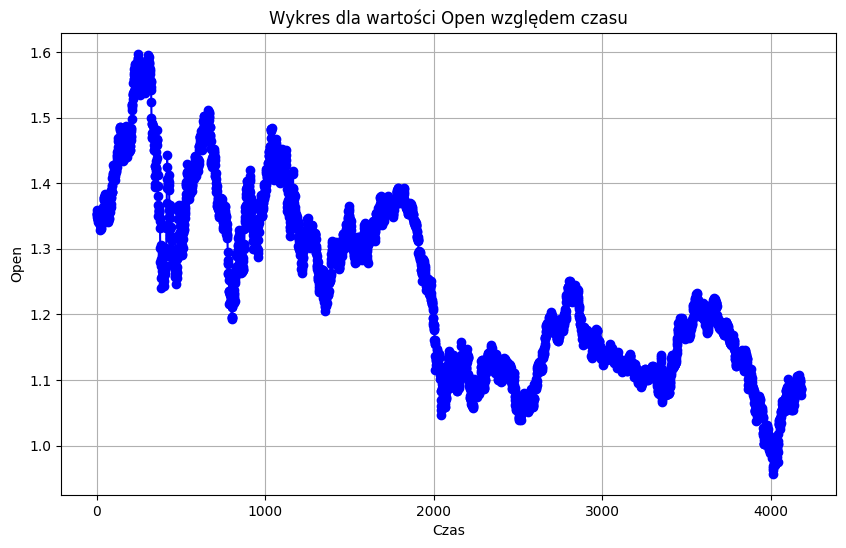

In [4]:

df : MyDataFrame = getDataPandas(eur_usd)
print('--------------checkDataQuality----------------')
checkDataQuality(df)
print('------------------------------')
df = prepearSingleCurrency(df)
print(df.drop(columns='WeekDay').describe())
print('-------------df.info()-----------------')
print(df.info())
print('-------------df.head(10)-----------------')
print(df.head(10))
print('-------------checkDataQuality-----------------')
checkDataQuality(df)
plotValueOverTime(df,'Open')